The model architecture: https://ieeexplore.ieee.org/document/8947839/similar#similar


In [1]:
# Import necessary packages
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch
from torchvision.io import read_image
import re
from PIL import Image
import matplotlib.pyplot as plt
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim
from tqdm import tqdm

Download dataset from kaggle

In [ ]:
!pip install kaggle

In [3]:
from google.colab import files
files.upload()  # Upload kaggle.json

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"eunicespak","key":"2d10dc86008d17d358cab63dedad35c8"}'}

In [4]:
import os
os.makedirs("/content/.kaggle", exist_ok=True)

# Move the kaggle.json file to .kaggle directory
!mv kaggle.json /content/.kaggle/

# Set permissions to the kaggle.json file
!chmod 600 /content/.kaggle/kaggle.json

In [ ]:
# Download the dataset
!kaggle datasets download -d shahrukhkhan/im2latex100k

# Unzip the downloaded dataset
!unzip im2latex100k.zip -d im2latex100k

Data preprocessing

In [6]:
import pandas as pd
from pathlib import Path

# Define dataset paths
data_dir = Path("/content/im2latex100k")
image_dir = data_dir / "formula_images_processed"
train_csv = data_dir / "im2latex_train.csv"
validate_csv = data_dir / "im2latex_validate.csv"
test_csv = data_dir / "im2latex_test.csv"
formulas_csv = data_dir / "im2latex_formulas.norm.csv"

In [7]:
# for building the vocab (testing later)
df = pd.read_csv(train_csv).dropna()

In [ ]:
# Create a vocabulary for tokenizing and encoding LaTeX formulas into numerical sequences
class Vocabulary():
    def __init__(self, freq_th=1):
        self.itos = {0:"[pad]",1:"[sos]",2:"[eos]",3:"[unk]"}
        self.stoi = {"[pad]":0,"[sos]":1,"[eos]":2,"[unk]":3}
        self.freq_th = freq_th

        #regex
        self.TOKENIZE_PATTERN = re.compile(
            "(\\\\[a-zA-Z]+)|" + '((\\\\)*[$-/:-?{-~!"^_`\[\]])|' + "(\w)|" + "(\\\\)"
        )

    def __len__(self):
        return len(self.itos)

    @staticmethod
    def tokenizer(TOKENIZE_PATTERN, formula: str):
        tokens = re.finditer(TOKENIZE_PATTERN, formula)
        tokens = list(map(lambda x: x.group(0), tokens))
        tokens = [x for x in tokens if x is not None and x != ""]
        return tokens

    def build_vocabulary(self,sentence_list):
        frequency = {}
        idx = 4
        for sentence in sentence_list:
            for word in self.tokenizer(self.TOKENIZE_PATTERN,sentence):
                if word not in frequency:
                    frequency[word] = 1
                else:
                    frequency[word] += 1

                if (word not in self.stoi and frequency[word] > self.freq_th-1):
                    self.itos[idx] = word
                    self.stoi[word] = idx
                    idx += 1

    def numericalize(self,sentence):
        tokenized_text = self.tokenizer(self.TOKENIZE_PATTERN,sentence)
        return [self.stoi[word] if word in self.stoi else self.stoi["[unk]"] for word in tokenized_text ] #UNK HOLDER

In [ ]:
v = Vocabulary(1)
v.build_vocabulary(df['formula'].tolist())
len(v.itos)

491

In [ ]:
# Preprocess input image
transform = transforms.Compose([
    transforms.Resize((224, 448)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:

class OCRDataset(Dataset):
    def __init__(self, csv_file, root_dir='/content/im2latex100k/', transform=None, threshold=1):
        self.root_dir = root_dir
        self.transform = transform

        # Label and image df
        self.df = pd.read_csv(csv_file).dropna()

        # initialize vocabulary
        self.vocab = Vocabulary(threshold)
        self.vocab.build_vocabulary(self.df['formula'].tolist()) # building vocab

    def __len__(self):
        return len(self.df)

    def __getitem__(self,index):
        row = self.df.iloc[index]
        img_path = os.path.join(self.root_dir, "formula_images_processed/formula_images_processed", row['image'])

        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        latex = row['formula'] #latex code
        num_to_tex = [self.vocab.stoi["[sos]"]]
        num_to_tex += self.vocab.numericalize(latex)
        num_to_tex.append(self.vocab.stoi["[eos]"])

        # return the pair
        return image,torch.tensor(num_to_tex) # image and num_to_tex

In [ ]:
train_dataset = OCRDataset(train_csv, data_dir, transform)

tensor([  1,  72,  33,  22,  30,  93,  25,   7,  26,  13, 150,   6,   7, 112,
         13,  47,  36,  93,  25,   7,  26,  13, 150,   6,   7, 112,  13,  54,
          2])
[sos] V = - g D ^ { 2 } \Gamma _ { 4 } + H D ^ { 2 } \Gamma _ { 4 } . [eos] 
V = - g D ^ { 2 } \Gamma _ { 4 } + H D ^ { 2 } \Gamma _ { 4 } .


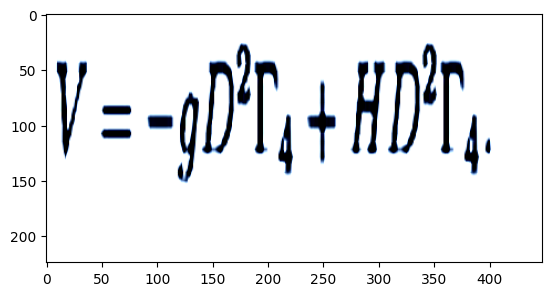

In [ ]:
# Testing OCRDataset class
#n = 674
#b,a = train_dataset.__getitem__(n)
#print(a)
#s = ""
#c=0
#for i in a:
    #c+=1
    #s+=train_dataset.vocab.itos[i.item()]
    #s+=" "
#print(s)
#print(df['formula'][n])
#plt.imshow(b.permute(1,2,0))
# plt.imshow(Image.open(os.path.join('/kaggle/input/im2latex100k/formula_images_processed/formula_images_processed/',df['image'][0])))

In [ ]:
# A custom collate function for a PyTorch DataLoader
class OCRCollate:
    def __init__(self,pad_idx):
        self.pad_idx = pad_idx

    def __call__(self, batch):
#         print(batch[0].shape)
        imgs = [item[0].unsqueeze(0) for item in batch]
        imgs = torch.cat(imgs,dim=0)
        targets = [item[1] for item in batch]
        targets = pad_sequence(targets, batch_first = True, padding_value = self.pad_idx)

        return imgs,targets

In [ ]:
def get_loader(csv_file, root_dir='/content/im2latex100k/', transform=transform, batch_size=32, num_workers=2, shuffle=True, pin_memory=True):
    dataset = OCRDataset(csv_file=csv_file, root_dir=root_dir, transform=transform)
    pad_value = dataset.vocab.stoi["[pad]"]

    loader = DataLoader(dataset=dataset, batch_size=32, num_workers=2, shuffle=True, pin_memory=True, collate_fn=OCRCollate(pad_value))

    return loader, dataset

In [ ]:
# Creating dataloader
train_loader, train_dataset = get_loader(csv_file = train_csv)
test_loader, test_dataset = get_loader(csv_file = test_csv)
val_loader, val_dataset = get_loader(csv_file = validate_csv)

Model architecture

In [ ]:
class EncoderCnn(nn.Module):
    def __init__(self,embed_size):
        super(EncoderCnn, self).__init__()

        #using pretrained model
        pretrained = models.resnet50(weights=True)
        #freezing training of weights
        for param in pretrained.parameters():
            param.requires_grad = False

        #getting all layers in list module and removed the last layer(we will add our own)
        modules = list(pretrained.children())[:-1]
        #putting final layers in out variable
        self.pretrained = nn.Sequential(*modules)

        #changing last layer and allow it to train
        self.fc = nn.Linear(pretrained.fc.in_features, embed_size)
        self.batch= nn.BatchNorm1d(embed_size,momentum = 0.01)
        self.fc.weight.data.normal_(0., 0.02)
        self.fc.bias.data.fill_(0)

    def forward(self,images):
        features = self.pretrained(images)
        #flattening to pass to fully connected layer
        features = features.view(features.size(0),-1)
        features = self.batch(self.fc(features))
        return features  #[batch, embed_size]

In [ ]:
class DecoderRnn(nn.Module):
    def __init__(self, embed_size,vocab_size, hidden_size, num_layers):
        super(DecoderRnn, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size) #[batch,seq] -> [batch,seq,embed]
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers,batch_first=True) #[batch,seq,embed]->hiddens[batch,seq,hidden_size]
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(0.5)

    def forward(self, features, caption):
        embeddings = self.dropout(self.embedding(caption)) #[batch,seq] -> [batch,seq,embed]
        embeddings = torch.cat((features.unsqueeze(1),embeddings), dim=1)
        hiddens, _ = self.lstm(embeddings)
        outputs = self.linear(hiddens)
        return outputs

In [ ]:
class CNN2RNN(nn.Module):
    def __init__(self, embed_size, vocab_size, hidden_size, num_layers):
        super(CNN2RNN, self).__init__()
        self.encoderCNN = EncoderCnn(embed_size)
        self.decoderRNN = DecoderRnn(embed_size, vocab_size, hidden_size, num_layers)

    def forward(self, images, caption):
        x = self.encoderCNN(images)
        x = self.decoderRNN(x, caption)
        return x

    def captionImage(self, image, vocabulary, maxlength=200):
        result_caption = []

        with torch.no_grad():
            x = self.encoderCNN(image).unsqueeze(0)
            print(x)
            states = None

            for _ in range(maxlength):
                hiddens, states = self.decoderRNN.lstm(x, states)
                output = self.decoderRNN.linear(hiddens.squeeze(0))
                predicted = output.argmax(1)
#                 print(predicted)
                result_caption.append(predicted.item())
#                 print(output.shape)
                x = self.decoderRNN.embedding(predicted).unsqueeze(0)
#                 print("x",x)
                if vocabulary.itos[predicted.item()] == "[eos]":
                    break
        return [vocabulary.itos[i] for i in result_caption]

Hyperparm tuning using Hyperband

In [ ]:
!pip install "ray[tune]"

In [ ]:
import ray
from ray import tune

In [ ]:
import os
print(os.listdir("im2latex100k"))

['im2latex_test.csv', 'im2latex_train.csv', 'im2latex_formulas.norm.csv', 'formula_images_processed', 'im2latex_validate.csv']


In [ ]:
def train_latex_ocr(config):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    train_loader, train_dataset = get_loader(csv_file = train_csv, batch_size=config['batch_size'])
    val_loader, val_dataset = get_loader(csv_file = validate_csv, batch_size=config['batch_size'])
    model = CNN2RNN(embed_size=config['embed_size'], hidden_size=config['hidden_size'], vocab_size=len(train_dataset.vocab), num_layers=config['num_layers']).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=train_dataset.vocab.stoi["[pad]"])
    optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'])


    # Training loop
    while True:
      for epoch in range(5):
          model.train()
          train_loss = 0.0
          for images, labels in train_loader:
              optimizer.zero_grad()
              outputs = model(images)
              loss = criterion(outputs, labels)
              loss.backward()
              optimizer.step()
              train_loss += loss.item()

          # Validation loop
          model.eval()
          val_accuracy = 0.0
          with torch.no_grad():
              for images, labels in val_loader:
                  outputs = model(images)
                  _, predicted = torch.max(outputs, 1)
                  val_accuracy += (predicted == labels).sum().item() / len(labels)

          # Report metrics to Ray Tune
          tune.report(mean_accuracy=val_accuracy / len(val_loader))

In [ ]:
from ray.tune.integration.keras import TuneReportCallback
from ray.tune.schedulers import HyperBandScheduler

hyperband_scheduler = HyperBandScheduler(
    time_attr='training_iteration',
    metric='mean_accuracy',
    mode='max',
    max_t=5,
    reduction_factor=3)

In [ ]:
analysis = tune.run(
    train_latex_ocr,
    name="exp",
        resources_per_trial={
            "gpu": 1,
            "cpu": 2
        },
    config={
      "lr": tune.uniform(0.001, 0.1),
      "batch_size": tune.grid_search([32,64,128]),
      "embed_size": tune.grid_search([128, 256, 300]),
      "hidden_size": tune.grid_search([128, 256, 300]),
      "num_layers": tune.grid_search([1, 2, 3])
    },
    scheduler=hyperband_scheduler)

+--------------------------------------------------------+
| Configuration for experiment     exp                   |
+--------------------------------------------------------+
| Search algorithm                 BasicVariantGenerator |
| Scheduler                        HyperBandScheduler    |
| Number of trials                 81                    |
+--------------------------------------------------------+

View detailed results here: /root/ray_results/exp
To visualize your results with TensorBoard, run: `tensorboard --logdir /tmp/ray/session_2024-12-15_23-37-58_996824_457/artifacts/2024-12-16_00-50-14/exp/driver_artifacts`

Trial status: 81 PENDING
Current time: 2024-12-16 00:50:15. Total running time: 0s
Logical resource usage: 0/2 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------+
| Trial name                    status            lr     batch_size     embed_size     hidde

Training

In [ ]:
save_model = True
step = 0
embed_size = 300
hidden_size = 300
num_layers = 2
num_epochs = 5
learning_rate = 1e-3
vocab_size = len(train_dataset.vocab)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
model = CNN2RNN(embed_size=embed_size, hidden_size=hidden_size, vocab_size=vocab_size, num_layers=num_layers).to(device=device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 143MB/s]


In [ ]:
loss_criterion = nn.CrossEntropyLoss(ignore_index=train_dataset.vocab.stoi["[pad]"])
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

In [ ]:
model.train()

for epoch in range(num_epochs):
    for imgs, captions in tqdm(train_loader):
        imgs = imgs.to(device)
        captions = captions.to(device)

        score = model(imgs, captions[:,:-1])
        optimizer.zero_grad()
        loss = loss_criterion(score.reshape(-1, score.shape[2]), captions.reshape(-1))

        step += 1

        loss.backward()
        optimizer.step()
    print(f"Loss for epoch {epoch}: {loss}")

    if save_model:
        save_path = f"/content/model_epoch_{epoch+1}.pth"
        torch.save(model.state_dict(), save_path)
        print(f"Model saved to {save_path}")

100%|██████████| 2353/2353 [08:27<00:00,  4.63it/s]


Loss for epoch 0: 1.7325776815414429
Model saved to /content/model_epoch_1.pth


100%|██████████| 2353/2353 [08:24<00:00,  4.67it/s]


Loss for epoch 1: 1.748704433441162
Model saved to /content/model_epoch_2.pth


100%|██████████| 2353/2353 [08:24<00:00,  4.67it/s]


Loss for epoch 2: 1.7802798748016357
Model saved to /content/model_epoch_3.pth


100%|██████████| 2353/2353 [08:21<00:00,  4.69it/s]


Loss for epoch 3: 1.681897521018982
Model saved to /content/model_epoch_4.pth


100%|██████████| 2353/2353 [08:20<00:00,  4.70it/s]


Loss for epoch 4: 1.5569219589233398
Model saved to /content/model_epoch_5.pth


Testing

In [ ]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
embed_size = 300
hidden_size = 300
num_layers = 2

In [ ]:
# Use the vocabulary from the train dataset
test_dataset.vocab.itos = train_dataset.vocab.itos
test_dataset.vocab.stoi = train_dataset.vocab.stoi

vocab_size = len(test_dataset.vocab)
print("Vocab size:", vocab_size)

Vocab size: 491


In [ ]:
# Initialize model (same architecture as training)
model = CNN2RNN(embed_size=embed_size, vocab_size=vocab_size, hidden_size=hidden_size, num_layers=num_layers).to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# Load the saved model weights
model.load_state_dict(torch.load("/content/model_epoch_5.pth", map_location=device))
model.eval()

# Define the loss function
loss_criterion = nn.CrossEntropyLoss(ignore_index=test_dataset.vocab.stoi["[pad]"])

<ipython-input-34-cc896021b37e>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/content/model_epoch_5.pth", map_location=device))


In [ ]:
# Testing loop
test_loss = 0.0
correct_tokens = 0
total_tokens = 0

with torch.no_grad():
    for imgs, captions in tqdm(test_loader, desc="Testing", leave=False):
        imgs = imgs.to(device)
        captions = captions.to(device)

        # forward pass
        outputs = model(imgs, captions[:, :-1])  # outputs shape: [batch_size, seq_length, vocab_size]

        # Compute loss
        # Flatten the outputs and targets for cross entropy
        loss = loss_criterion(outputs.reshape(-1, outputs.shape[2]), captions.reshape(-1))
        test_loss += loss.item()

        # Compute accurac
        predicted_tokens = outputs.argmax(dim=2)  # [batch_size, seq_length]
        mask = (captions != test_dataset.vocab.stoi["[pad]"])
        correct_tokens += ((predicted_tokens == captions) & mask).sum().item()
        total_tokens += mask.sum().item()

# Compute final metrics
avg_test_loss = test_loss / len(test_loader)
token_accuracy = 100.0 * correct_tokens / total_tokens if total_tokens > 0 else 0.0

print(f"Test Loss: {avg_test_loss:.4f}")
print(f"Token-Level Accuracy (ignoring pads): {token_accuracy:.2f}%")

Test Loss: 1.5732
Token-Level Accuracy (ignoring pads): 61.84%


Testing with our own handwritten math formula images

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Path
handwritten_images_folder = "/content/drive/MyDrive/pngs/"

In [ ]:
# same parameters as in training
embed_size = 300
hidden_size = 300
num_layers = 2
vocab_size = len(train_dataset.vocab)

# model
model = CNN2RNN(embed_size=embed_size, vocab_size=vocab_size, hidden_size=hidden_size, num_layers=num_layers).to(device)
model.load_state_dict(torch.load("/content/model_epoch_5.pth", map_location=device))
model.eval()

In [ ]:
# vocabulary from the training dataset
vocab = train_dataset.vocab

In [ ]:
# Function to run inference on a single image
def predict_formula(image_path):
    image = Image.open(image_path).convert("RGB")

    image = transform(image).unsqueeze(0)  # add batch dimension [1,3,H,W]
    image = image.to(device)

    # generate caption (prediction)
    predicted_tokens = model.captionImage(image, vocab)
    # predicted_tokens is a list of tokens, e.g. ["[sos]", "x", "=", ... "[eos]"]
    # Remove [sos] and [eos]
    if predicted_tokens and predicted_tokens[0] == "[sos]":
        predicted_tokens = predicted_tokens[1:]
    if predicted_tokens and predicted_tokens[-1] == "[eos]":
        predicted_tokens = predicted_tokens[:-1]

    # Join tokens to form the predicted LaTeX formula
    predicted_formula = "".join(predicted_tokens)
    return predicted_formula

Predicting:   0%|          | 0/185 [00:00<?, ?it/s]

tensor([[[ 9.5171e-03,  9.7373e-01,  2.0039e-02,  2.5060e-01,  1.7637e+00,
           1.6847e-01,  1.8386e-01,  1.4023e+00, -4.2089e-01,  8.3299e-01,
           1.0023e+00, -2.4484e-01, -5.9210e-01,  1.5705e+00, -7.3747e-01,
           8.0421e-01, -1.0093e+00, -2.9242e-01, -9.6543e-01,  8.5696e-01,
          -3.9725e-01,  1.1217e+00,  6.9124e-01, -4.4260e-01,  5.5675e-01,
           9.3707e-01, -3.4202e-01, -2.1667e-02,  1.0352e+00,  8.4075e-02,
          -2.0975e+00,  9.9604e-01, -2.3662e+00, -2.2784e-01, -4.6760e-01,
          -7.2368e-01, -1.5652e-01,  2.2853e-01, -2.4284e-01,  3.0950e-01,
           9.7358e-01, -3.7442e-01, -1.4103e+00, -1.4159e+00, -2.1276e+00,
          -7.5269e-01, -3.6615e-01, -7.9202e-01, -1.1325e-01, -5.1806e-01,
           1.1628e-01,  1.0415e+00,  6.4242e-01,  4.8829e-01,  1.1985e+00,
           5.3745e-02,  1.5009e-01, -1.6201e+00,  1.4834e+00,  4.0276e-01,
          -6.0661e-01, -1.0266e-01, -3.9684e-01,  1.3960e-01,  1.9424e-02,
           3.2739e-01,  1

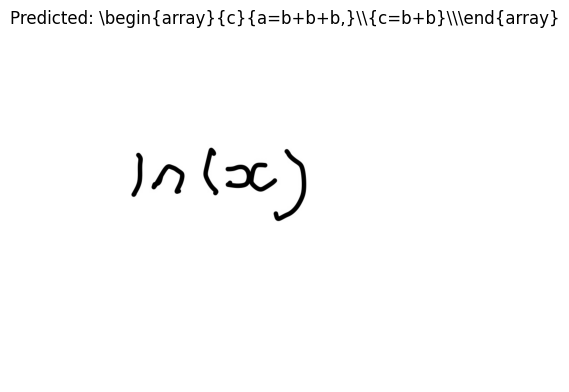

Predicting:   1%|          | 1/185 [00:00<01:17,  2.37it/s]

tensor([[[-9.3196e-02,  7.9465e-01, -4.9993e-01,  6.1034e-01,  1.3069e+00,
           2.8075e-01, -2.1027e-02,  1.7928e+00, -1.8480e-01,  6.5685e-01,
           1.1010e+00, -3.8246e-01, -1.0508e+00,  1.3612e+00, -4.1855e-01,
          -3.1222e-01, -7.3924e-01, -1.0286e-01, -1.2222e+00,  9.3117e-01,
          -7.3780e-01,  1.5021e+00,  2.7453e-01, -4.6062e-01,  5.4843e-01,
           7.4187e-01, -3.0486e-01, -1.0093e-01,  9.7628e-01, -1.1185e-02,
          -8.0352e-01,  1.2474e+00, -1.4577e+00, -1.4354e+00,  1.0495e-01,
          -2.0994e-01, -3.2461e-01, -3.6198e-01,  2.1074e-01,  2.0154e-01,
           1.5499e+00,  1.0467e-01, -3.4879e-01, -7.1997e-01, -1.4789e+00,
          -3.4758e-01, -1.0260e+00, -5.7647e-01, -3.4495e-01, -4.8892e-01,
          -1.6656e-01,  3.2643e-02,  1.1918e+00,  3.5767e-01,  3.0015e-01,
           1.1128e+00, -2.4371e-01, -1.3763e+00,  1.1104e+00,  5.0328e-02,
          -1.8501e-01, -4.0486e-01, -4.6660e-01,  7.3127e-01, -6.9921e-02,
           2.8786e-01,  2

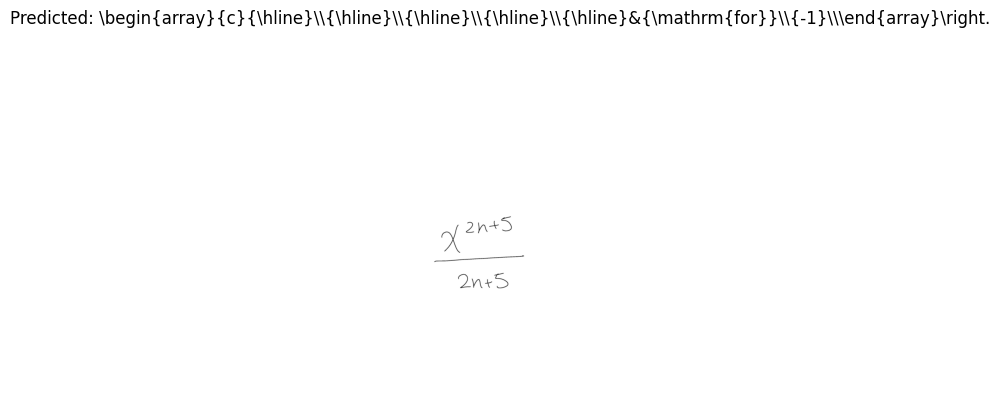

Predicting:   1%|          | 2/185 [00:01<01:46,  1.71it/s]

tensor([[[-2.5606e-01,  1.5333e+00, -3.4555e-01,  5.1729e-01,  2.2991e+00,
           5.6238e-01, -1.9444e-01,  1.7105e+00,  5.4859e-01,  1.0288e+00,
           1.7218e+00, -5.9012e-01, -1.3224e-01,  1.5271e+00, -1.3683e+00,
           9.7937e-01, -1.0836e+00, -6.5773e-01, -1.9894e+00,  5.8206e-01,
          -1.2284e+00,  9.9668e-01,  9.1879e-02, -6.2669e-01, -7.3792e-02,
           1.4513e+00, -9.0484e-02,  3.0170e-01,  9.4487e-01, -7.8229e-01,
           2.9218e-01,  9.7069e-01, -2.4953e+00, -5.8369e-01,  5.6820e-01,
          -2.4670e-01, -3.8967e-01, -8.0182e-01, -1.1706e-01,  9.0927e-01,
           8.6429e-01, -1.7861e-02, -2.8825e-01,  2.5365e-01, -8.5450e-01,
          -2.6394e-01, -1.4944e+00, -3.1421e-01, -1.4915e-01,  6.7695e-02,
           2.1955e-01,  2.3219e-01,  2.1480e-03,  4.9886e-01,  5.9302e-01,
          -6.5023e-02, -5.6304e-01, -8.0059e-01,  1.3262e+00,  2.3500e-01,
          -1.0276e+00, -1.0376e+00, -6.3059e-01,  9.9114e-01, -1.5501e-01,
          -2.4046e-01,  8

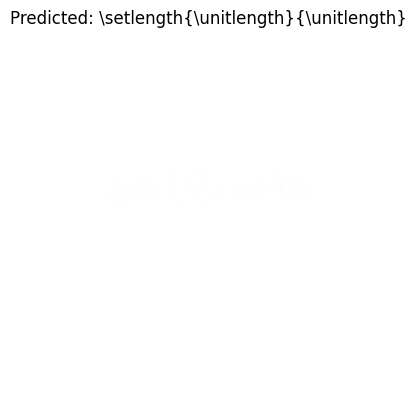

Predicting:   2%|▏         | 3/185 [00:01<01:26,  2.11it/s]

tensor([[[ 0.2837,  0.5284, -0.0438,  0.2644,  1.0654, -0.0255,  0.2506,
           1.0157, -0.8694,  0.2281,  0.4303, -0.1378,  0.0621,  0.5505,
          -0.3314,  2.0738, -0.9540,  0.1193, -0.7942,  1.2232,  0.0045,
           1.5494,  0.0993, -0.1896,  0.5109,  0.5860, -0.7588, -0.4112,
           1.3904,  0.3470, -0.9006,  0.8838, -0.4421, -0.1507, -0.2818,
          -0.5162,  0.0513,  0.5209, -0.3215, -0.0042,  1.5919, -0.4174,
          -0.6776, -1.2564, -1.8451, -0.8334, -0.2318, -0.9685,  0.2527,
           0.0310,  0.1408,  0.9041,  0.9715,  0.5437,  0.7592, -0.3733,
           0.1527, -1.7941,  1.1774,  0.3788, -0.5714, -0.1510, -0.0885,
          -0.1216, -0.0943,  0.5637,  1.6295, -0.1148, -1.4938,  1.4610,
          -0.4358, -0.5707, -0.5615,  0.2783, -0.3590, -0.8545,  0.8644,
          -1.0158,  0.3826, -1.0961, -1.2299,  1.4190,  0.0670, -0.2899,
          -0.4794,  0.4024,  0.5632,  1.3070, -0.8051,  0.4035,  0.1047,
           0.0368, -0.1614,  0.6924,  0.3418, -0.37

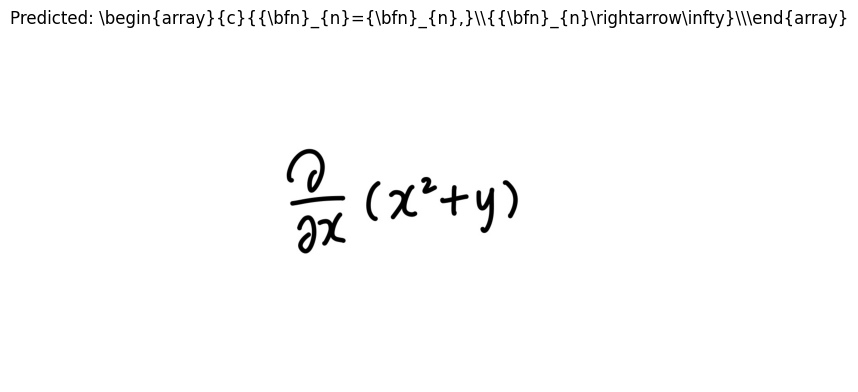

Predicting:   2%|▏         | 4/185 [00:01<01:20,  2.26it/s]

tensor([[[ 2.6270e-01,  1.0281e+00, -1.0914e+00,  1.9723e-01,  1.9454e+00,
           2.6320e-01,  2.4283e-01,  1.8638e+00,  2.0451e-01,  7.0706e-01,
           3.7320e-01, -2.1640e-01, -9.8943e-01,  1.7343e+00, -7.3668e-01,
           6.9474e-01, -1.5570e+00, -1.4741e-01, -1.7925e+00,  6.9926e-01,
          -9.7860e-01,  1.5237e+00, -2.3240e-01, -2.5515e-01,  1.0260e+00,
           6.0649e-01, -2.7626e-01, -3.8326e-01,  1.2610e+00, -7.2607e-02,
          -1.1589e+00,  9.3401e-01, -7.0814e-01, -4.7747e-01,  2.5116e-01,
           2.6876e-01, -4.0341e-01, -1.1547e+00, -9.3439e-02,  4.4491e-01,
           6.6574e-01, -5.1061e-01, -1.5271e+00, -2.7287e-01, -1.6060e+00,
          -4.8464e-01, -9.8813e-01, -1.0897e+00, -1.2615e-01, -5.7030e-01,
          -5.6591e-01, -2.3707e-01,  2.8518e-01,  6.0856e-01,  8.1534e-01,
          -8.0478e-01,  1.8950e-02, -5.4169e-01,  1.0586e+00,  2.7973e-01,
          -5.3758e-01, -4.7361e-01, -4.6001e-01,  7.6236e-01, -2.7635e-01,
           1.5067e-01,  1

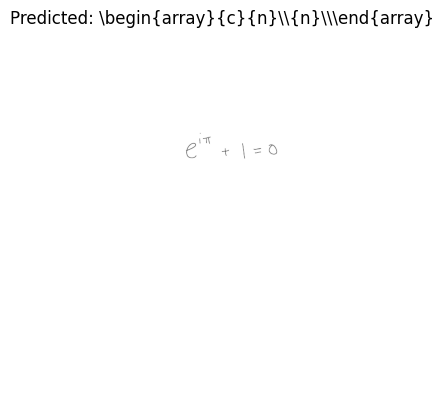

Predicting:   3%|▎         | 5/185 [00:02<01:11,  2.51it/s]

tensor([[[ 6.5280e-02,  5.5264e-01, -8.1132e-01,  2.8924e-01,  1.1453e+00,
           4.2795e-01,  1.1827e-01,  1.8778e+00,  2.8321e-03,  4.7232e-01,
          -2.5694e-01, -4.9079e-01, -1.6710e+00,  1.1812e+00, -9.6847e-01,
           5.6610e-01, -1.2899e+00, -6.2895e-01, -1.5723e-01,  7.6156e-01,
          -1.2339e-01,  1.1200e+00,  7.0211e-01,  6.7504e-02,  1.6582e+00,
          -7.4507e-01, -3.0628e-01, -1.0546e-01,  1.0876e+00,  5.7579e-01,
          -1.9770e+00,  9.2434e-01, -1.3597e+00, -1.9237e+00, -1.1710e-01,
           3.8229e-01, -4.0873e-01, -2.6682e-01,  2.1828e-02,  4.0282e-01,
           1.1535e+00, -1.4205e-01, -1.1068e+00, -1.5949e+00, -1.6602e+00,
          -1.4101e+00,  2.2062e-01, -1.3722e+00,  4.9724e-02, -1.0178e+00,
          -6.5139e-03, -3.0673e-01,  7.3277e-01,  6.1147e-03,  1.0953e+00,
           8.5199e-02,  1.2057e-01, -1.1349e+00,  1.4537e+00,  3.3348e-01,
          -9.7745e-02,  2.1693e-01, -4.4095e-01,  3.2991e-01, -3.0325e-01,
          -2.7748e-01,  1

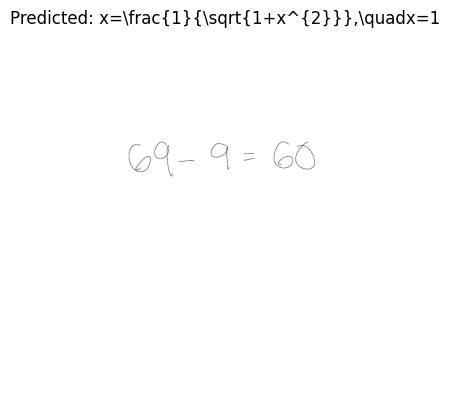

Predicting:   3%|▎         | 6/185 [00:02<01:05,  2.73it/s]

tensor([[[ 3.1666e-01,  4.0601e-01, -5.4549e-02,  2.5554e-01,  8.7842e-01,
           3.1431e-04,  3.1650e-01,  1.2965e+00, -9.6187e-01,  3.4141e-01,
           2.4348e-01, -4.6537e-02, -1.8463e-01,  7.7296e-01, -3.6896e-01,
           1.9324e+00, -2.6214e+00,  4.9380e-01, -6.9942e-01,  9.9004e-01,
           8.9281e-01,  7.9684e-01,  5.1070e-01, -2.8241e-01,  1.6074e-01,
          -2.0509e-01, -4.7555e-01, -4.2881e-01,  1.3732e+00,  6.0701e-01,
          -4.8765e-01,  8.4007e-01, -1.6417e+00, -7.6538e-01, -6.5464e-01,
          -7.6478e-01,  5.3115e-02,  5.3933e-01, -2.2420e-01,  2.2017e-01,
           1.3251e+00, -1.1313e+00, -9.6301e-01, -1.6246e+00, -1.6637e+00,
          -8.5872e-01,  5.2880e-01, -7.6787e-01,  1.7721e-01, -3.0546e-01,
          -5.6009e-02,  9.1185e-01,  9.1086e-01,  4.9569e-01,  1.0419e+00,
          -4.1181e-01,  6.9510e-01, -7.4431e-01,  1.4104e+00,  5.3218e-01,
           1.5513e-01,  6.4722e-01,  6.5083e-02, -4.7221e-01, -7.8811e-02,
           1.1292e+00,  1

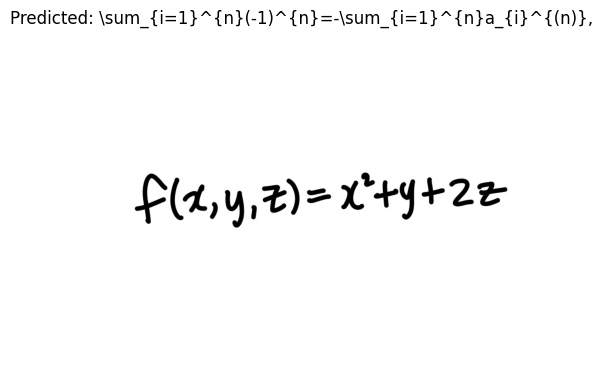

Predicting:   4%|▍         | 7/185 [00:02<01:08,  2.61it/s]

tensor([[[-0.1224,  0.9992, -0.2349,  0.4962,  1.1102, -0.0453,  0.2621,
           1.3117, -0.4732,  0.6661,  1.1214, -0.1548, -0.1979,  0.8683,
          -1.0423,  1.2151, -1.4883, -0.2786, -1.5199,  1.1251, -0.2385,
           0.9473,  0.1797, -0.3033,  0.4045,  0.8853, -0.4268, -0.2118,
           1.1891,  0.0568, -1.3119,  0.8632, -1.9201, -0.7266, -0.1539,
          -0.6534, -0.3092,  0.1698,  0.0462,  0.2356,  1.2601, -0.3444,
          -0.6012, -1.0340, -1.9521, -0.9922, -0.3900, -0.8322, -0.1734,
          -0.5276,  0.2593,  0.5188,  1.1187,  0.4443,  1.1121, -0.0416,
           0.0826, -1.7754,  1.6122,  0.2674, -0.6858, -0.2968, -0.4367,
           0.4954, -0.0952,  0.3259,  1.9913, -0.1568, -1.4898,  2.1094,
           0.2203, -0.4301, -0.3040,  0.5299,  0.1609, -0.6836,  0.6082,
          -1.1887, -0.1288, -1.2025, -1.1594,  1.5661,  1.2706, -1.1894,
          -0.6560,  0.4251, -0.2548,  0.6660, -0.9799, -0.1597, -0.7446,
           0.7235, -1.3984,  0.2513,  0.3481,  0.18

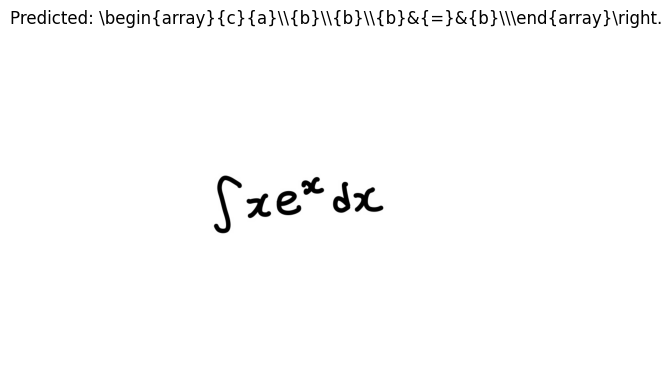

Predicting:   4%|▍         | 8/185 [00:03<01:09,  2.55it/s]

tensor([[[ 7.5108e-02,  8.1642e-01, -4.0302e-01,  4.7301e-01,  7.8443e-01,
           1.3243e-01,  1.3416e-01,  1.5981e+00, -3.7214e-01,  6.7810e-02,
           2.3761e-01, -3.3919e-01, -1.5061e+00,  8.2494e-01, -8.0085e-01,
           1.6301e-01, -1.0469e+00, -7.8432e-01,  6.5058e-01,  1.0329e+00,
           4.3696e-01,  5.6333e-01,  2.8584e-01, -9.6386e-02,  1.5820e+00,
          -5.8809e-01,  2.6941e-01,  1.3557e-03,  1.1499e+00,  1.0379e+00,
          -2.0953e+00,  6.1425e-01, -2.0591e+00, -3.0706e+00,  8.0166e-02,
          -3.9475e-01, -1.9493e-01,  1.9305e-01, -1.0495e-01,  2.1656e-01,
           1.8600e+00, -4.8175e-01, -6.3529e-01, -1.7871e+00, -2.3749e+00,
          -1.1458e+00,  9.8731e-01, -1.4062e+00,  1.2003e-01, -7.4790e-01,
           3.9637e-01,  1.2617e-01,  8.6779e-01,  2.7904e-01,  1.2863e+00,
           7.7071e-01,  2.5370e-01, -1.1270e+00,  1.5130e+00,  3.2524e-01,
           1.8897e-01,  7.5798e-01, -4.5033e-01,  1.4279e-02, -1.6937e-01,
           3.7913e-01,  2

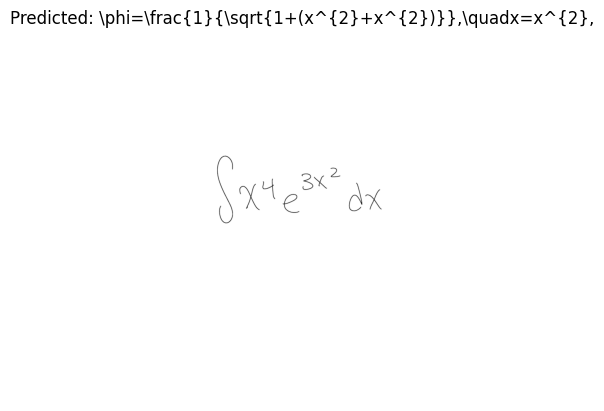

Predicting:   5%|▍         | 9/185 [00:03<01:00,  2.91it/s]

tensor([[[-9.0756e-02,  1.0101e+00, -6.9813e-01,  4.4129e-01,  8.3093e-01,
          -4.9507e-02,  2.9231e-01,  1.6066e+00, -5.2526e-01,  6.0156e-01,
           1.0870e+00,  1.9662e-01,  7.0094e-01,  1.6402e+00, -5.1462e-01,
           7.7694e-01, -1.3073e+00, -2.5757e-01, -2.3006e+00,  1.0596e+00,
          -8.2294e-01,  1.1720e+00, -5.1105e-01, -2.5269e-01,  2.7446e-01,
           2.0700e+00, -3.6388e-01, -1.2389e-01,  1.5240e+00, -7.7223e-03,
          -3.6864e-01,  1.3031e+00, -3.4846e+00, -3.9229e-01, -1.2637e-01,
          -1.0562e+00, -4.2426e-01, -2.0418e-01,  5.9728e-01,  3.2707e-01,
           1.0496e+00, -4.2695e-02, -7.7506e-01, -3.0079e-01, -1.3481e+00,
          -2.7751e-01, -1.4313e+00, -1.1331e+00, -3.9301e-01, -4.6843e-01,
           8.2178e-04,  2.2312e-01,  9.6074e-01,  7.4666e-01,  6.1851e-01,
          -9.7865e-01, -1.0737e-01, -1.7070e+00,  1.4560e+00,  2.7403e-01,
          -9.6377e-01, -1.3813e+00, -4.9997e-01,  5.6047e-01, -1.7745e-01,
           1.0040e+00,  1

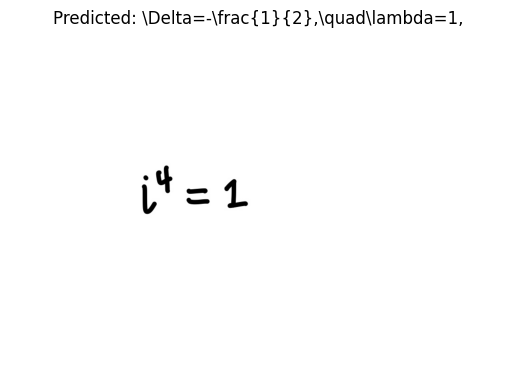

Predicting:   5%|▍         | 9/185 [00:03<01:14,  2.36it/s]


In [ ]:
# Limit to first 10 images
max_examples = 10
count = 0

for img_name in tqdm(os.listdir(handwritten_images_folder), desc="Predicting"):
    if img_name.lower().endswith(".png"):
        img_path = os.path.join(handwritten_images_folder, img_name)

        # Predict formula
        formula = predict_formula(img_path)

        # Load image for display
        image = Image.open(img_path).convert("RGB")

        # Display image and prediction
        plt.figure()
        plt.imshow(image)
        plt.axis('off')
        plt.title(f"Predicted: {formula}")
        plt.show()

        count += 1
        if count >= max_examples:
            break